## Basket option pricing with neural network and Monte Carlo solver
The goal of this project is to build an artifical neural network to price European basket options. For brevity, I limited this analysis to call options. 

This is a proof-of-concept of an accelerated options pricing model. Therefore, I used simulated data to train the network. Levy's 1992 moment matching method was used to generate simulated basket option prices; Levy's formula assumes homogenous volatility of the underlying assets, and no volatility skew for deep in-the-money or out-of-the-money options. To realize the advantages of a neural network approach in a real-world setting--which could include accurately modelling behaviour that violates Black-Scholes--we would want to collect a large dataset of historical option prices. Without training on historical data, the limitations of the neural network model will almost certainly be the same as the limitations of Levy's formula.

This analysis is organized as follows:
1. Simulate approximate prices of 10,000 European basket options using Levy's formula.
1. Train a fully-connected artifical neural network to estimate option prices.
1. For a subset of the testing data, compare option prices from the neural network model with those from a Monte Carlo solver.
1. To compare with Black-Scholes for the single-asset case, either a) re-train on single-asset options or b) try setting all but one of the prices/weights to zero in the network input.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from src.simulation import SimulateBasketPrices
from src.nn_train import PricingNetwork
from src.options import BasketOption

In [2]:
sns.set_style('whitegrid')

In [3]:
tf.random.set_seed(321)
np.random.seed(123)

#### 1. Simulate approximate prices with Levy's formula

In [4]:
# Average price of the simulated assets. The 
# simulator will add normal noise to all simulated assets. 
prices = np.ones(4)*100.
# Average volatility of simulated assets. The simulator
# will add a small uniform random on [-0.025,0.025).
vol = 0.4
# For each simulated basket, the underlying assets have the 
# same correlation structure.
corr = np.array([[1.,0.5,0.5,0.5],
                 [0.5,1.,0.5,0.5],
                 [0.5,0.5,1.,0.5],
                 [0.5,0.5,0.5,1.]])

In [5]:
# Simulate 10,000 baskets, each with 4 underlying assets 
simulator = SimulateBasketPrices(4, n_prices=10000)
# The simulation routine uses the BasketOption class defined in options.py
simulated_prices = simulator.simulate_prices(prices, vol, corr)

#### 2. Train a neural network model to estimate option prices

In [6]:
train_prices = simulated_prices.sample(frac=0.8, random_state=123)
test_prices = simulated_prices.drop(train_prices.index)

X_train, X_test = train_prices.copy(), test_prices.copy()
y_train, y_test = X_train.pop('Basket_Price'), X_test.pop('Basket_Price')

In [7]:
# The PricingNetwork class has the model build, compilation, and
# testing functionality.
pricer = PricingNetwork((X_train, y_train), (X_test, y_test))

2021-12-29 18:24:12.451316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The model has 4+2(N_assets) input features:
* N features for the price of each asset
* N features for the weight of each asset in the basket
* Strike price
* Maturity date
* Volatility (all assets have equal volatility for the Levy formula)
* Risk-free interest rate (set to zero for simplicity)

The model architecture is inspired by Ke & Yang 2019 (capstone project for Stanford CS230). They found a 4-layer network with ReLU activations and batch normalization to work well. Therefore, the network I implement here has three layers with 256 nodes each and a final layer with a single node. The first three layers are followed by batch norm. I also chose to normalize the features before passing into the neural network.

Throughout training, the validation loss was lower than the training loss. This could be a quirk of the random train/test split and isn't terribly concerning for this simulated dataset, which has the same distributions for train and test. In a real world dataset of historical prices, I would look try a cross-validation to avoid this sort of variance in performance estimation.  

In [8]:
pricer.create_ann()
# Fit the model using the Adam optimizer and MSE loss function
history = pricer.fit_model(epochs=100)

Epoch 1/100
250/250 [==============================] - 2s 3ms/step - loss: 404.1216 - val_loss: 196.8958
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 89.6520 - val_loss: 193.5773
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 49.6049 - val_loss: 129.2677
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 33.5318 - val_loss: 40.1175
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 25.8033 - val_loss: 25.4213
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 21.7448 - val_loss: 6.9604
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 19.0597 - val_loss: 9.3446
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 16.4722 - val_loss: 5.2241
Epoch 9/100
250/250 [==============================] - 1s 3ms/step - loss: 14.8592 - val_loss: 4.1482
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - los

In [9]:
test_prices['ANN_Price'] = pricer.pricing_model.predict(X_test)
test_prices['Model_Error'] = abs(test_prices.ANN_Price - test_prices.Basket_Price)
test_prices['Log_Error'] = np.log10(test_prices['Model_Error'])
# Get ratio of weighted asset price to strike price
test_prices['wS/K'] = (test_prices.iloc[:,[0,1,2,3]].to_numpy()\
                       *test_prices.iloc[:,[4,5,6,7]].to_numpy()).sum(axis=1) / test_prices['Strike']

From the description below, the test set **mean absolute error (MAE) of the network is 0.554** with range [4.41e-4, 33.88].

In [10]:
test_prices.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,99.937571,100.030452,100.128235,100.214959,0.251805,0.247513,0.252507,0.248174,100.042777,8.108500,0.399955,0.0,37.011902,37.431469,0.554248,-0.429521,1.098351
std,10.208839,9.913643,9.981491,10.116169,0.134666,0.137108,0.137075,0.136743,28.886819,4.316717,0.014468,0.0,14.568432,14.326503,0.893589,0.450110,0.360206
min,63.251973,69.502320,68.261599,64.805747,0.000896,0.000219,0.000229,0.000928,50.003862,1.000000,0.375030,0.0,0.924878,0.000000,0.000441,-3.355544,0.579738
25%,92.921248,93.298141,93.375828,93.238979,0.150122,0.142407,0.152136,0.145992,75.326070,4.000000,0.387688,0.0,27.421528,28.090986,0.238571,-0.622382,0.797876
50%,100.186662,100.155392,100.074790,100.029244,0.253997,0.249541,0.253336,0.247768,98.802742,8.000000,0.399977,0.0,38.122577,38.626377,0.462263,-0.335111,1.001821
75%,107.025016,106.529756,106.894122,106.578535,0.343896,0.341301,0.343690,0.339035,125.754931,12.000000,0.412597,0.0,47.761817,47.857597,0.739118,-0.131286,1.332280
max,131.804283,138.822470,133.444092,140.680969,0.848419,0.896097,0.860552,0.808793,149.997277,15.000000,0.424976,0.0,72.222488,72.204117,33.879210,1.529933,2.186009


Visual inspection of the pairplot below suggests no strong relationships between model error and the input features.

In [11]:
#sns.pairplot(test_prices[['Strike','Maturity','Volatility','Basket_Price','wS/K','Log_Error']])
#plt.savefig('figures/network_performance_pairplot.pdf')

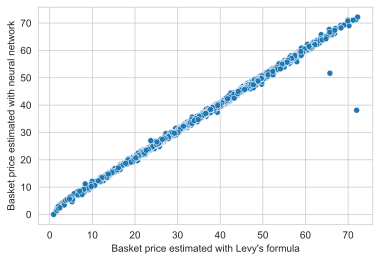

In [43]:
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=test_prices)
_=plt.xlabel("Basket price estimated with Levy's formula")
_=plt.ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-levy_test-data.png')

Note that both outliers (top rows below) had the maximum possible time to maturity (15) and a fairly high price-to-strike ratio. 

In [35]:
test_prices.sort_values('Model_Error', ascending=False)

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K
6773,121.757964,107.182926,93.261674,102.213401,0.047163,0.690561,0.099223,0.163053,53.977999,15,0.411421,0.0,72.000899,38.121689,33.879210,1.529933,1.957811
635,114.409629,119.328206,119.412493,100.555255,0.060732,0.222900,0.143909,0.572459,67.784024,15,0.391898,0.0,65.735732,51.652000,14.083732,1.148718,1.597646
9753,101.054237,105.305594,100.310233,111.739415,0.149427,0.014136,0.100008,0.736428,93.970894,1,0.418740,0.0,23.715396,27.007805,3.292409,0.517514,1.158963
9772,104.281889,95.269742,114.074027,96.099375,0.762507,0.131877,0.009074,0.096542,118.378322,1,0.378842,0.0,8.327690,11.185990,2.858300,0.456108,0.864958
6825,94.353250,84.714147,94.480495,102.797191,0.045008,0.616077,0.069554,0.269361,66.216055,1,0.415309,0.0,27.241083,29.588017,2.346933,0.370501,1.369730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,91.974238,108.010273,112.050591,102.096442,0.293608,0.313035,0.256627,0.136729,55.507154,6,0.387023,0.0,54.613843,54.616135,0.002292,-2.639786,1.865169
1393,85.705562,97.778557,80.474589,93.334574,0.155415,0.342949,0.266685,0.234951,55.539288,5,0.409962,0.0,42.565020,42.567081,0.002061,-2.685819,1.624857
3592,89.994628,106.721397,112.872304,94.976413,0.013213,0.348607,0.068543,0.569637,93.511915,14,0.381283,0.0,49.081382,49.079559,0.001822,-2.739383,1.071859
5088,99.166754,95.417137,87.809822,118.148474,0.285871,0.365551,0.132525,0.216053,70.338971,15,0.378964,0.0,55.791107,55.792183,0.001076,-2.968385,1.427261


#### 3. Compare a subset of the test cases to a Monte Carlo solver

In [13]:
subset = test_prices.iloc[:100]

In [14]:
mc_prices = []
for i in range(subset.shape[0]):
    opt = BasketOption(
        subset.iloc[i,4:8].to_numpy(),
        subset.iloc[i,:4].to_numpy(),
        subset.iloc[i].Volatility,
        corr,
        subset.iloc[i].Strike,
        subset.iloc[i].Maturity,
        subset.iloc[i].Rate
    )

    mc_prices.append(opt.get_mc_price(n_paths=2000000))

subset['MC_Price'] = mc_prices

/var/folders/wy/ybnn2vf96m38d53m5xdft1ch0000gn/T/ipykernel_95575/178142683.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['MC_Price'] = mc_prices


In [15]:
subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])

/var/folders/wy/ybnn2vf96m38d53m5xdft1ch0000gn/T/ipykernel_95575/2212790973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ANN-MC_Error'] = abs(subset['ANN_Price'] - subset['MC_Price'])


From the description below, **mean absolute error (MAE) of the network is 0.85** with range [2.15e-2, 2.06] (relative to Monte Carlo).

In [16]:
subset.describe()

,Price_1,Price_2,Price_3,Price_4,Weight_1,Weight_2,Weight_3,Weight_4,Strike,Maturity,Volatility,Rate,Basket_Price,ANN_Price,Model_Error,Log_Error,wS/K,MC_Price,ANN-MC_Error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,99.038408,99.378233,100.060430,99.930234,0.224519,0.255158,0.241083,0.279241,95.585104,8.780000,0.401733,0.0,39.507200,39.991135,0.549271,-0.409372,1.131680,39.157299,0.849642
std,10.590967,9.567476,9.435509,9.747892,0.123810,0.122364,0.127059,0.125431,26.847684,4.375275,0.014479,0.0,13.816793,13.545568,0.395427,0.433697,0.339782,13.670347,0.454896
min,71.663425,77.182476,75.751637,78.405584,0.002799,0.008791,0.012470,0.043153,52.556779,1.000000,0.375659,0.0,5.499500,6.961343,0.008508,-2.070180,0.632013,5.489363,0.021502
25%,92.093974,92.603908,94.656050,94.497170,0.139158,0.185623,0.155137,0.214058,71.898710,5.000000,0.391255,0.0,28.406015,28.894710,0.268570,-0.570969,0.843040,28.122739,0.506219
50%,99.845334,100.583688,99.791063,99.664907,0.231841,0.255067,0.244201,0.278182,94.309480,9.000000,0.402708,0.0,39.521048,40.082027,0.464140,-0.333399,1.046450,39.355568,0.796073
75%,106.248417,104.563239,107.014474,104.460689,0.301047,0.332805,0.323302,0.354487,114.360091,12.000000,0.414521,0.0,50.133120,51.059197,0.729451,-0.137013,1.409298,49.662099,1.152000
max,122.142420,120.272487,119.594113,135.715792,0.575822,0.623859,0.582195,0.808793,147.295476,15.000000,0.424878,0.0,61.290458,61.946270,1.849713,0.267104,1.930046,60.785784,2.060408


Visual inspection of the pairplot suggests a relationship between strike price and absolute error between the Monte Carlo (MC) estimates and the neural network estimates.

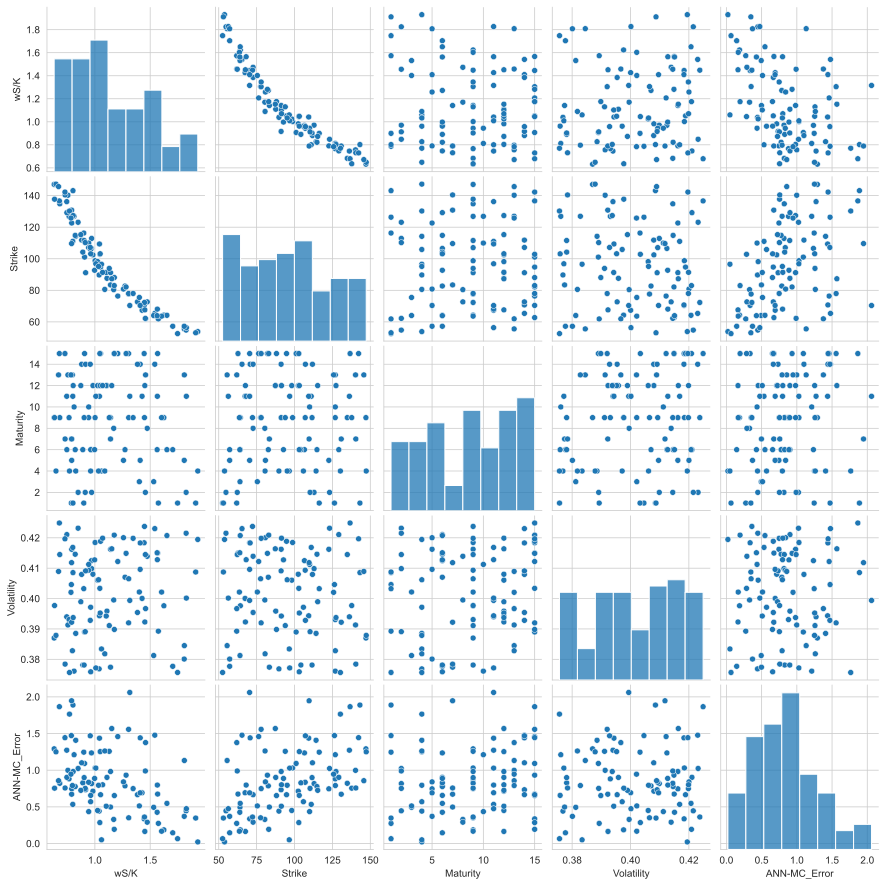

In [17]:
sns.pairplot(subset[['wS/K','Strike','Maturity','Volatility','ANN-MC_Error']])

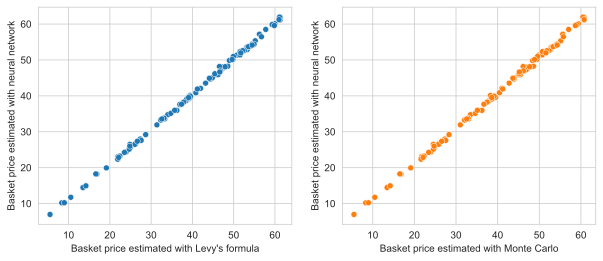

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x='Basket_Price', y='ANN_Price', data=subset, ax=ax[0])
sns.scatterplot(x='MC_Price', y='ANN_Price', data=subset, ax=ax[1], color='C1')

_=ax[0].set_xlabel("Basket price estimated with Levy's formula")
_=ax[0].set_ylabel("Basket price estimated with neural network")
_=ax[1].set_xlabel("Basket price estimated with Monte Carlo")
_=ax[1].set_ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-mc_prices.png')

#### 4. Compare neural network and Monte Carlo to Black-Scholes for one-asset option
Since the Levy model reduces to Black-Scholes for the one-asset option, the neural network performance demonstrated above should be similar to the one-asset case if we were to re-train on BS for one-asset options. Instead, a more interesting study is to explore what happens when we use the 4-asset neural network with a one-asset option as an input. I did this by inputting the price of the single asset as all prices in the 4-asset network, with very small weights for the last 3 assets. E.g. for a single-asset option with an asset price of 100, I input prices=[100,100,100,100] and weights=[0.997, 0.001, 0.001, 0.001] into the network. 

This may give us some insight into the possibility of training a single network that is somewhat agnostic to the number of underlying assets in the basket option.

In [19]:
# 100 one-asset options 
one_simulator = SimulateBasketPrices(1, n_prices=100)

price = np.array([100,])
vol = 0.4
corr = np.array([[1,]])
simulated_prices = one_simulator.simulate_prices(price, vol, corr)

In [20]:
mc_prices = []
ann_prices = []

# For each row in the simulated prices, create an option and price with MC and ANN
for i in range(len(simulated_prices)):
    opt = BasketOption(
        np.array([simulated_prices.iloc[i,1],]),
        np.array([simulated_prices.iloc[i,0],]),
        simulated_prices.iloc[i].Volatility,
        corr,
        simulated_prices.iloc[i].Strike,
        simulated_prices.iloc[i].Maturity,
        simulated_prices.iloc[i].Rate
    )
    mc_prices.append(opt.get_mc_price(n_paths=2000000))
    ann_prices.append(opt.get_ann_price(pricer.pricing_model))

In [37]:
simulated_prices['MC_Prices'] = mc_prices
simulated_prices['ANN_Prices'] = ann_prices
simulated_prices['ANN-BS_Error'] = abs(simulated_prices['Basket_Price'] - simulated_prices['ANN_Prices'])
simulated_prices['S/K'] = simulated_prices['Price_1'] / simulated_prices['Strike']

As seen below, the error between Black-Scholes and the neural network (trained on 4-asset basket options but "tricked" into processing one-asset options) is **MAE=6.10** with range [1.11e-3, 78.8]. 

In [38]:
simulated_prices.describe()

,Price_1,Weight_1,Strike,Maturity,Volatility,Rate,Basket_Price,MC_Prices,ANN_Prices,ANN-BS_Error,S/K
count,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
mean,100.123177,1.0,100.236018,8.230000,0.400383,0.0,43.077325,43.096287,39.894215,6.101393,1.102903
std,9.817762,0.0,30.496121,4.622857,0.014742,0.0,16.355601,16.365091,16.680498,15.882703,0.376537
min,77.643153,1.0,52.813506,1.000000,0.376593,0.0,2.162989,2.158393,0.000000,0.001110,0.587200
25%,93.397044,1.0,73.850880,3.750000,0.387676,0.0,32.042466,32.047081,29.993861,0.856340,0.791570
50%,99.960531,1.0,97.548354,9.000000,0.398708,0.0,43.657852,43.716237,41.750828,1.858516,1.036566
75%,106.961998,1.0,128.236008,12.250000,0.412376,0.0,55.295679,55.469935,53.248756,2.725709,1.315735
max,121.149924,1.0,147.814989,15.000000,0.424797,0.0,78.845341,78.723148,66.469734,78.845341,2.046211


In [39]:
simulated_prices.sort_values('ANN-BS_Error', ascending=False)

,Price_1,Weight_1,Strike,Maturity,Volatility,Rate,Basket_Price,MC_Prices,ANN_Prices,ANN-BS_Error,S/K
94,120.011568,1.0,70.856227,13,0.411053,0.0,78.845341,78.723148,0.000000,78.845341,1.693734
57,110.950340,1.0,57.500454,14,0.399484,0.0,76.100112,76.125753,0.000000,76.100112,1.929556
7,116.654073,1.0,98.986491,15,0.415003,0.0,71.457432,71.728558,0.000000,71.457432,1.178485
26,117.851522,1.0,84.989245,13,0.395818,0.0,70.783257,70.757381,0.000000,70.783257,1.386664
48,115.407702,1.0,126.532375,15,0.406538,0.0,63.348910,63.215464,0.000000,63.348910,0.912080
...,...,...,...,...,...,...,...,...,...,...,...
52,108.067569,1.0,52.813506,7,0.393942,0.0,65.916708,65.733242,65.979385,0.062677,2.046211
58,82.195100,1.0,96.940824,9,0.398490,0.0,33.270026,33.316660,33.210339,0.059687,0.847889
66,100.235419,1.0,62.786834,2,0.377859,0.0,41.806331,41.802366,41.756275,0.050056,1.596440
24,85.766440,1.0,98.155884,8,0.378745,0.0,31.574743,31.574216,31.539001,0.035741,0.873778


In the plot below, "Basket_Price" refers to Black-Scholes pricing.

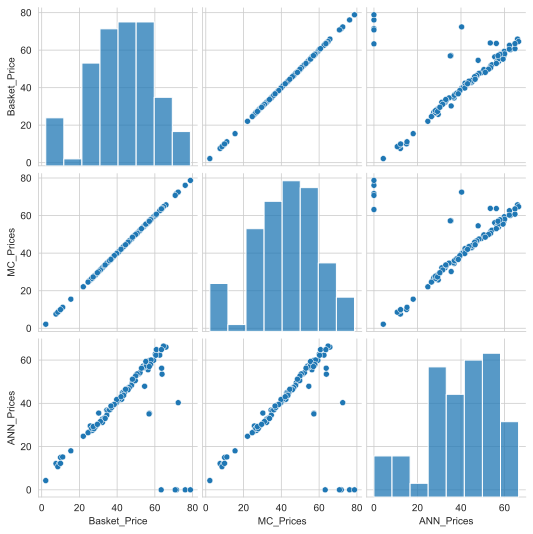

In [23]:
_=sns.pairplot(simulated_prices[['Basket_Price','MC_Prices','ANN_Prices']])

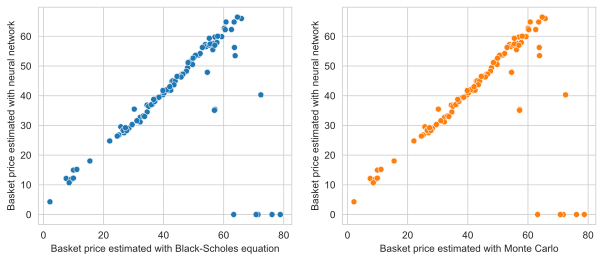

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x='Basket_Price', y='ANN_Prices', data=simulated_prices, ax=ax[0])
sns.scatterplot(x='MC_Prices', y='ANN_Prices', data=simulated_prices, ax=ax[1], color='C1')

_=ax[0].set_xlabel("Basket price estimated with Black-Scholes equation")
_=ax[0].set_ylabel("Basket price estimated with neural network")
_=ax[1].set_xlabel("Basket price estimated with Monte Carlo")
_=ax[1].set_ylabel("Basket price estimated with neural network")
plt.savefig('figures/nn-mc-bs_prices.png')

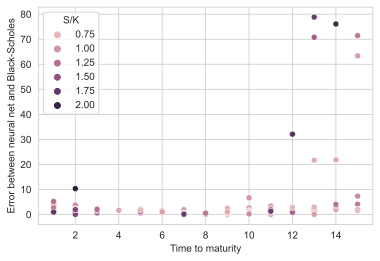

In [49]:
sns.scatterplot(x='Maturity', y='ANN-BS_Error', hue='S/K', data=simulated_prices)
_=plt.ylabel('Error between neural net and Black-Scholes')
_=plt.xlabel('Time to maturity')
plt.savefig('figures/bs-ann-error_maturity.png')